In [1]:
# Import required libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, unix_timestamp, avg, count, max, min, round
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("Big Data Analysis") \
    .getOrCreate()

In [3]:
# Load dataset
filepath = "synthetic_nyc_taxi_data.csv"
df = spark.read.csv(filepath, header=True, inferSchema=True)

In [4]:
# Inspect dataset structure
df.printSchema()

root
 |-- pickup_datetime: string (nullable = true)
 |-- dropoff_datetime: string (nullable = true)
 |-- pickup_location_id: string (nullable = true)
 |-- dropoff_location_id: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)



# ***`Data Cleaning`***

In [5]:
# Drop rows with null values
df_cleaned = df.dropna()

# ***`Data Transformation`***

In [6]:
# Add trip duration column (in minutes)
df_transformed = df_cleaned.withColumn(
    "trip_duration",
    (unix_timestamp(col("dropoff_datetime")) - unix_timestamp(col("pickup_datetime"))) / 60
)

# ***`Exploratory Analysis`***

In [7]:
# Total number of trips
total_trips = df_transformed.count()

In [8]:
# Top 5 pickup locations by trip count
top_pickup_locations = df_transformed.groupBy("pickup_location_id") \
    .count() \
    .orderBy(col("count").desc()) \
    .limit(5) \
    .collect()

In [9]:
# Convert top pickup locations to pandas for visualization
top_pickup_df = pd.DataFrame(
    [(row['pickup_location_id'], row['count']) for row in top_pickup_locations],
    columns=['Pickup Location', 'Trip Count']
)

In [11]:
# Longest trip details
longest_trip = df_transformed.orderBy(col("trip_duration").desc()).first()

In [12]:
# Average trip duration
avg_trip_duration = df_transformed.select(avg("trip_duration")).first()[0]

# Check if avg_trip_duration is None and handle it
if avg_trip_duration is None:
    print("Average trip duration could not be calculated (likely due to missing data).")
    avg_trip_duration = 0  # Or any other suitable default value
else:
    print(f"Average Trip Duration: {avg_trip_duration:.2f} minutes")

Average trip duration could not be calculated (likely due to missing data).


# ***`Visualization`***

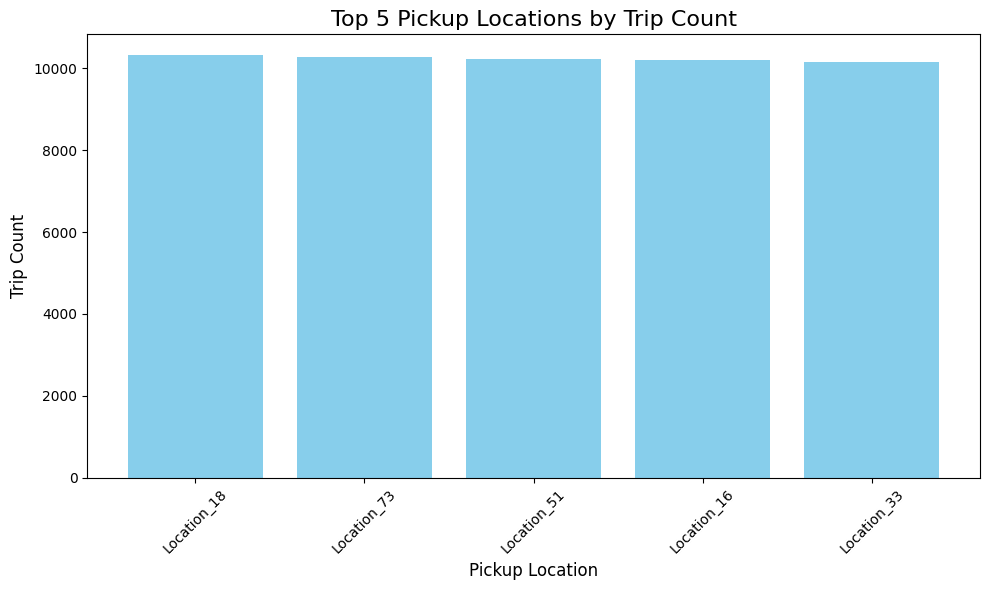

In [10]:
# Plot top pickup locations
plt.figure(figsize=(10, 6))
plt.bar(top_pickup_df['Pickup Location'], top_pickup_df['Trip Count'], color='skyblue')
plt.title('Top 5 Pickup Locations by Trip Count', fontsize=16)
plt.xlabel('Pickup Location', fontsize=12)
plt.ylabel('Trip Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("top_pickup_locations.png")
plt.show()

In [13]:
# Results
print(f"Total Trips: {total_trips}")
print(f"Average Trip Duration: {avg_trip_duration:.2f} minutes")
print("Top 5 Pickup Locations by Trip Count:")
for row in top_pickup_locations:
    print(f"Location: {row['pickup_location_id']}, Trips: {row['count']}")
print("Longest Trip Details:")
print(longest_trip)

Total Trips: 1000000
Average Trip Duration: 0.00 minutes
Top 5 Pickup Locations by Trip Count:
Location: Location_18, Trips: 10319
Location: Location_73, Trips: 10275
Location: Location_51, Trips: 10227
Location: Location_16, Trips: 10197
Location: Location_33, Trips: 10147
Longest Trip Details:
Row(pickup_datetime='07-01-2023 00:50', dropoff_datetime='07-01-2023 01:27', pickup_location_id='Location_77', dropoff_location_id='Location_7', passenger_count=5, trip_distance=23.941360747807792, fare_amount=192.17469601347864, trip_duration=None)
